# CoMEt mutual exclusion analysis
## Read CoMEt output

In [2]:
source("~/smartas/pipeline/scripts/variablesAndFunctions.r")

# read comet output for each tumor
me <- list()
for (tumor in cancerTypes){
    me[[tumor]] <- read_tsv(paste0("../data/structural_analysis/comet_output/",tumor,"/results/comet.k4.2M.1.tsv"))  %>%
        set_colnames(c("Freq","TotalWeight","TargetWeight","Geneset","phi","WeigthF")) %>% 
        # remove non-significant cases
        filter(phi<0.05) %>%
        # consider only those that involve a switch
        filter(grepl("-uc",Geneset)) %>%
        mutate(Tumor=tumor)
}
me <- do.call("rbind",me)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



### Convert Ensembl proteins ids to other annotations

In [3]:
# map ensembl proteins to entrez ids
library(biomaRt)

# get ensembl proteins
ensp <- unlist(strsplit(me$Geneset,", ", fixed=T)) %>%
    strsplit(.,"-") %>%
    unlist %>%
    grep("ENSP",.,value=TRUE) %>%
    unique

# define biomart object
ensembl <- useMart(biomart = "ENSEMBL_MART_ENSEMBL", dataset = "hsapiens_gene_ensembl",host="www.ensembl.org")

# query biomart
dict <- getBM(attributes=c("entrezgene","ensembl_peptide_id","hgnc_symbol"), 
                 filters="ensembl_peptide_id", values = ensp, mart = ensembl) %>%
    # make sure we take only cases we need
    filter(ensembl_peptide_id %in% ensp)

# create dictionay
ensp2entrez <- setNames(dict$entrezgene, dict$ensembl_peptide_id)
ensp2hgnc <- setNames(dict$hgnc_symbol, dict$ensembl_peptide_id)

# replace ensembl proteins for entrez ids
meEntrezs <- strsplit(me$Geneset,", ", fixed=T) %>%
    lapply(function(x){gsub("-uc.+$","",x)}) %>%
    lapply(function(x){as.character(ensp2entrez[x])})

meHgnc <- strsplit(me$Geneset,", ", fixed=T) %>%
    lapply(function(x){gsub("-uc.+$","",x)}) %>%
    lapply(function(x){as.character(ensp2hgnc[x])})

# remove redundant cases
meEntrezs.sorted <- lapply(meEntrezs,sort)
uniq.meEntrezs <- meEntrezs.sorted %>% unique

## Consider only the ones that affect tumor-specific drivers

In [52]:
intogenDictionary <- c("coread"="coad","hc"="lihc","rccc"="kirc")

# read drivers
drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>% 
    # remove those genes with no observed me
    filter(geneHGNCsymbol %in% dict$hgnc_symbol) %>% 
    mutate(Tumor_type=tolower(Tumor_type)) %>%
    mutate(Tumor_type=revalue(Tumor_type,intogenDictionary))%>%
    filter(Tumor_type %in% cancerTypes)

mutatedHgnc <- strsplit(me$Geneset,", ", fixed=T) %>%
    lapply(function(x) grep("-uc.+$",x,value=TRUE,invert=TRUE)) %>%
    lapply(function(x) as.character(ensp2hgnc[x]) )
        
driverNum <- list()
for (i in 1:nrow(me)){
    tumor <- me$Tumor[i]
    driverNum[[i]] <- intersect(mutatedHgnc[[i]],drivers$geneHGNCsymbol[drivers$Tumor_type==tumor]) %>%
        length
}
    
driverNum <- do.call("rbind",driverNum)
mutatedGenes <- lapply(mutatedHgnc,length) %>% as.numeric
me$SpecificDrivers <- driverNum/mutatedGenes

In [61]:
# cases where mutual exclusion is detected only between switches
sum(driverNum==0 & mutatedGenes==0)

[1] 4513

In [62]:
sum(me$SpecificDrivers == 1,na.rm=T)
sum(me$SpecificDrivers == 1,na.rm=T)/nrow(me) * 100

[1] 578

[1] 3.240819

In 578 cases (3.24%) mutual exclusion involves only tumor-specific drivers and switches.

## Look for agreement with known genesets
We will use known genesets to make sense of the mutually exclusive genes. Although it is not strictly necessary, if we can associate one of the known genesets to the groups those gain robustness and, more importantly, we have a biological hypothesis on the affected function. Any group that displays at least two components from the same geneset will be considered annotated (let's assume that the probability of two components of the same process co-occurring in one group is very low).

In [29]:
gsOverlap <- list()

# read the different genesets
sets <- c("c2.cp.v4.0.entrez.gmt","c5.bp.v4.0.entrez.gmt",
          "c6.all.v4.0.entrez.gmt","h.all.v5.0.entrez.gmt")
for (gmt in sets){
    gmtfile <- paste0("../data/genesets/",gmt)
    no_col <- max(count.fields(gmtfile,sep = "\t"))
  
    # read table
    gs <- read.table(gmtfile,header=F,fill=T,col.names=1:no_col) %>%
            .[,-2]
    gsNames <- gs$X1

    # convert to list of character vectors
    gs <- apply(gs,1,function(x){ 
            as.character(x[2:length(x)][!is.na(x[2:length(x)])]) 
        })
    names(gs) <- gsNames

    # get overlap between list and each geneset
    gsOverlap[[gmt]] <- lapply(uniq.meEntrezs,function(x){
        # get genesets with the bigger intersection, concatenated with commas
        intersection <- lapply(gs, intersect, x) %>% lapply(length) %>% unlist
        topGS <- names(gs)[intersection==max(intersection)] %>% paste(collapse=",")
        list(intersection=max(intersection),genesets=topGS)
    }) %>% do.call("rbind",.)
}

gsOverlap <- do.call("cbind",gsOverlap)
# number of genes in common between sets
intersection <- gsOverlap[,c(T,F)]
# names of the genesets
genesets <- gsOverlap[,c(F,T)]

# remove those cases where intersection is 1 or less (i.e. there is nothing to the genes)
genesets[intersection <= 1] <- NA

In [ ]:
# get genesets
unique(cbind(intersection[!is.na(genesets)],genesets[!is.na(genesets)])) %>%
    as.data.frame %>%
    set_colnames(c("Counts","Geneset")) %>%
    arrange(desc(Counts))

In [111]:
# genesets where a pathway could be associated
meEntrezs.pw <- uniq.meEntrezs[as.logical(rowSums(intersection > 1))]
#meHgnc[as.logical(rowSums(intersection > 1))] ### FIX
## indexes
meEntrezs.relevant <- meEntrezs.sorted %in% meEntrezs.pw

# match each geneset to the associated pathways
pwOrder <- meEntrezs.sorted[meEntrezs.relevant] %>%
    lapply(function(x){Position(function(y) identical(y, x), meEntrezs.pw, nomatch = 0)}) %>%
    as.numeric
                       
hq.me <- me %>% 
    filter(meEntrezs.relevant) %>%
    select(Tumor,Geneset) %>%
    cbind(as.character(genesets[!is.na(genesets)][pwOrder])) %>%
    cbind(as.character(lapply(meHgnc[meEntrezs.relevant][pwOrder],paste,collapse=","))) %>%
    set_colnames(c("Tumor","Genes","Geneset","HGNC")) %>%
    # remove cases with very long genes
    filter(!grepl("OBSCN",HGNC))
                       
hq.me

,Tumor,Genes,Geneset,HGNC
1,coad,"ENSP00000224337-uc001kls.3-uc001klx.3, ENSP00000281092-uc003kop.1-uc011cvg.1, ENSP00000361565-uc004emy.1-uc004emz.2, ENSP00000446385","REACTOME_SIGNALING_BY_GPCR,REACTOME_GPCR_DOWNSTREAM_SIGNALING","BLNK,FER,RBM41,NA"
2,coad,"ENSP00000228437-uc001tmp.2-uc010sww.1, ENSP00000310123-uc002mfa.2-uc002mez.2, ENSP00000365308-uc001ita.2-uc010qdg.1, ENSP00000408342-uc002mkd.2-uc002mkc.2","REACTOME_SIGNALING_BY_GPCR,REACTOME_GPCR_DOWNSTREAM_SIGNALING","PRDM4,CRB3,ABI1,PRAM1"
3,coad,"ENSP00000224337-uc001kls.3-uc001klx.3, ENSP00000321976, ENSP00000346080-uc003fhc.3-uc003fhb.3, ENSP00000375267-uc004eyf.2-uc004eyg.3","REACTOME_SIGNALING_BY_GPCR,REACTOME_GPCR_DOWNSTREAM_SIGNALING","BLNK,NKPD1,RPL22L1,FAM127B"
4,coad,"ENSP00000224337-uc001kls.3-uc001klx.3, ENSP00000318406-uc001byx.2-uc001byw.2, ENSP00000361565-uc004emy.1-uc004emz.2, ENSP00000470152-uc010dmj.2-uc002kxx.2","REACTOME_SIGNALING_BY_GPCR,REACTOME_GPCR_DOWNSTREAM_SIGNALING","BLNK,KIAA0319L,RBM41,DTNA"
5,coad,"ENSP00000228437-uc001tmp.2-uc010sww.1, ENSP00000255087-uc001ooc.2-uc001ooe.2, ENSP00000264094-uc002smp.1-uc002smo.1, ENSP00000380276-uc002uhw.3-uc002uhv.3",REACTOME_IMMUNE_SYSTEM,"PRDM4,MTL5,LOXL3,RAPGEF4"
6,coad,"ENSP00000258749-uc003tfh.3-uc011kba.1, ENSP00000299213-uc002ass.2-uc002ast.2, ENSP00000369785, ENSP00000376197-uc003fwa.3-uc011btr.1",REACTOME_IMMUNE_SYSTEM,"NA,LARP6,PIR,TFRC"
7,coad,"ENSP00000228437-uc001tmp.2-uc010sww.1, ENSP00000289672-uc003tny.1-uc003tob.2, ENSP00000374037-uc002fom.1-uc002fol.1, ENSP00000470152-uc010dmj.2-uc002kxx.2",REACTOME_IMMUNE_SYSTEM,"PRDM4,PKD1L1,VPS9D1,DTNA"
8,coad,"ENSP00000264094-uc002smp.1-uc002smo.1, ENSP00000265512-uc003hun.2-uc011ced.1, ENSP00000369785, ENSP00000376197-uc003fwa.3-uc011btr.1",REACTOME_SIGNALING_BY_GPCR,"LOXL3,ADH4,PIR,TFRC"
9,coad,"ENSP00000234038-uc002wat.1-uc002was.2, ENSP00000375267-uc004eyf.2-uc004eyg.3, ENSP00000380276-uc002uhw.3-uc002uhv.3, ENSP00000470152-uc010dmj.2-uc002kxx.2","REACTOME_SIGNALING_BY_GPCR,REACTOME_GPCR_DOWNSTREAM_SIGNALING","PPP1R7,FAM127B,RAPGEF4,DTNA"
10,coad,"ENSP00000228437-uc001tmp.2-uc010sww.1, ENSP00000264094-uc002smp.1-uc002smo.1, ENSP00000314949, ENSP00000380276-uc002uhw.3-uc002uhv.3","REACTOME_SIGNALING_BY_GPCR,REACTOME_GPCR_DOWNSTREAM_SIGNALING","PRDM4,LOXL3,NA,RAPGEF4"


In [114]:
table(hq.me$Tumor)


coad kich kirc kirp luad lusc 
  72   30    8   31    3    4 

Surprisingly, there are some cancer types where the no mutual exclusion groups is associated to a stablished biological meaning.

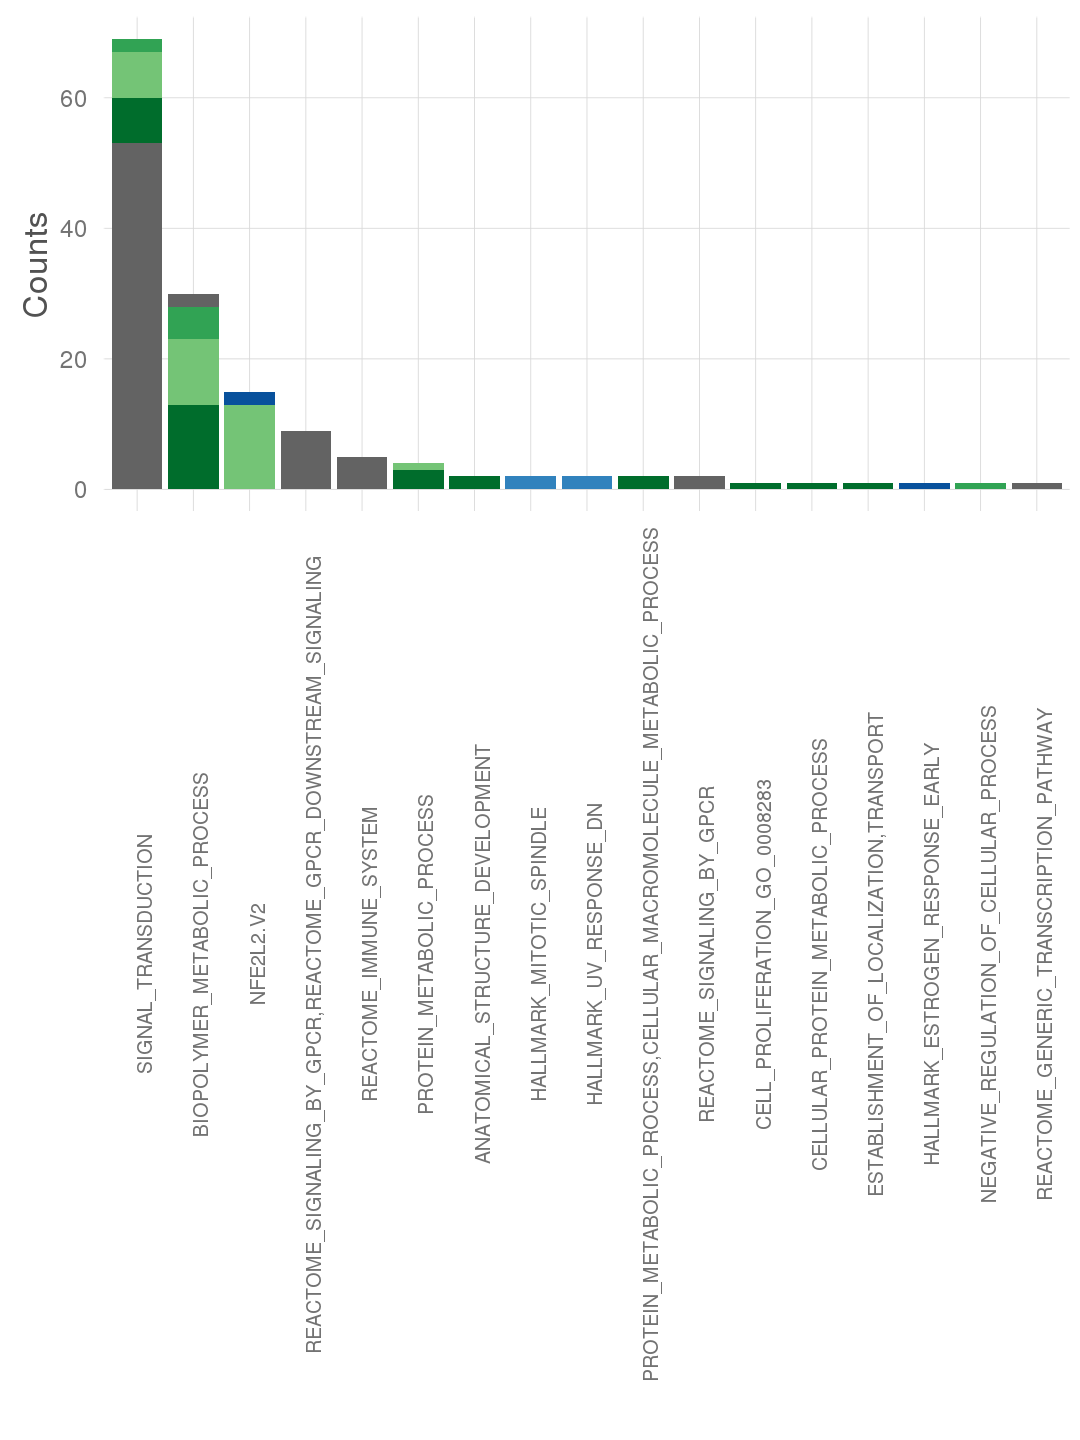

In [168]:
options(repr.plot.width=9, repr.plot.height=12)

hq.me %>%
    select(Tumor,Geneset) %>%
    table %>%
    melt %>%
    arrange(desc(value)) %>%
    mutate(Geneset=factor(Geneset,levels=unique(Geneset)),
           Tumor=factor(Tumor,levels=cancerTypes)) %>%
    ggplot(aes(fill=Tumor,y=value,x=Geneset)) +
        geom_bar(stat="identity") +
        scale_fill_manual(values=colorPalette) + 
        smartas_theme() +
        labs(x="",y="Counts") +
        theme(axis.text.x=element_text(angle=90,size=12))

The most common genesets seem not very informative (signal transduction, biopolymer metabolic process).